In [1]:
!pip install nltk
!pip install textblob
!pip install wordcloud

   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
   -- ------------------------------------ 41.0/626.3 kB 393.8 kB/s eta 0:00:02
   ------ ------------------------------- 112.6/626.3 kB 819.2 kB/s eta 0:00:01
   ------------- -------------------------- 204.8/626.3 kB 1.1 MB/s eta 0:00:01
   ----------------------- ---------------- 368.6/626.3 kB 1.6 MB/s eta 0:00:01
   ----------------------------------- ---- 553.0/626.3 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 626.3/626.3 kB 2.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   --- ----------------------------------- 30.7/300.2 kB 435.7 kB/s eta 0:00:01
   ---------- ---------------------------- 81.9/300.2 kB 651.6 kB/s eta 0:00:01
  

In [2]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
from sklearn.metrics import classification_report

In [3]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
df = pd.read_csv("headphone_datn.csv", sep=",")
df.head()

,Customer_Name,REVIEW_TITLE,Color,REVIEW_DATE,COMMENTS,RATINGS
0,Ramdika,Really Exceed my expectation.,Black,30-May-21,Okay.. I was skeptical at first to buy this as...,5
1,Sachin AK,Great for a change from inear buds,Black,01-Jun-21,The earphone is worth what you pay for. The de...,5
2,Manikandan Raj,For people with sensitive ears,Black,05-Sep-21,"Particularly for people with sensitive ears, w...",4
3,Reviewguy,I tested it for a week and here's a detailed r...,Iguana,11-Sep-21,Built Quality 6.5 10The lower wire is a durabl...,4
4,Sridhar Sarkar,Not a good headphone,Iguana,26-Jun-21,Don't go with the over all 4 start rating. Thi...,2


# Ön işleme adımı

In [7]:
df['COMMENTS'] = df['COMMENTS'].str.lower()

In [8]:
df['COMMENTS'] = df['COMMENTS'].str.replace('[^\w\s]', '', regex=True)


In [9]:
df['COMMENTS'] = df['COMMENTS'].str.replace('\d', '',regex=True)

In [11]:
import nltk
nltk.download('stopwords')
sw = stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alper\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [12]:
df['COMMENTS'] = df['COMMENTS'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))


In [13]:
temp_df = pd.Series(' '.join(df['COMMENTS']).split()).value_counts()

drops = temp_df[temp_df <= 1]

df['COMMENTS'] = df['COMMENTS'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

In [15]:
nltk.download("punkt")
df["COMMENTS"].apply(lambda x: TextBlob(x).words).head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alper\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


0    [okay, first, buy, tight, budget, honest, litt...
1    [earphone, worth, pay, design, earbud, may, ca...
2    [people, sensitive, ears, gets, ear, pain, wea...
3    [built, quality, lower, wire, durable, nylon, ...
4    [dont, go, start, boat, brand, lot, money, mar...
Name: COMMENTS, dtype: object

In [16]:
nltk.download('wordnet')
df['COMMENTS'] = df['COMMENTS'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alper\AppData\Roaming\nltk_data...


In [17]:
tf = df["COMMENTS"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

tf.columns = ["words", "tf"]

tf.sort_values("tf", ascending=False)

,words,tf
49,good,677.00
63,quality,544.00
0,sound,491.00
15,product,443.00
23,earphone,277.00
...,...,...
623,indeed,2.00
621,immediately,2.00
620,cancel,2.00
619,chinese,2.00


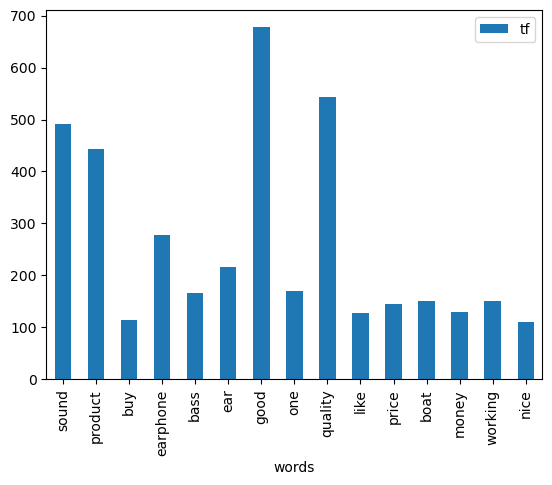

In [18]:
tf[tf["tf"] > 100].plot.bar(x="words", y="tf")
plt.show()

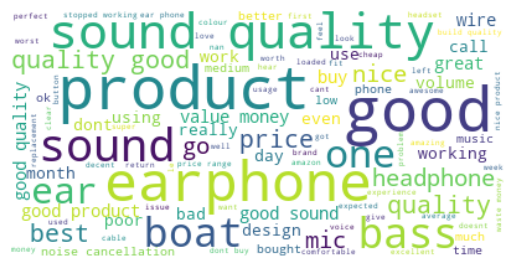

In [19]:
text = " ".join(i for i in df.COMMENTS)
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [20]:
 nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Alper\AppData\Roaming\nltk_data...


True

In [21]:
sia = SentimentIntensityAnalyzer()
df["COMMENTS"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df["sentiment_label"] = df["COMMENTS"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

In [22]:
df["sentiment_label"].value_counts()


sentiment_label
pos    1034
neg     570
Name: count, dtype: int64

In [23]:
df.groupby("sentiment_label")["RATINGS"].mean()


sentiment_label
neg   2.16
pos   4.09
Name: RATINGS, dtype: float64

In [24]:
df["sentiment_label2"] = LabelEncoder().fit_transform(df["sentiment_label"])


In [25]:
train_x,test_x,train_y,test_y =train_test_split(df["COMMENTS"],df["sentiment_label2"],random_state=42)


In [26]:
df.head()


,Customer_Name,REVIEW_TITLE,Color,REVIEW_DATE,COMMENTS,RATINGS,sentiment_label,sentiment_label2
0,Ramdika,Really Exceed my expectation.,Black,30-May-21,okay first buy tight budget honest little prod...,5,pos,1
1,Sachin AK,Great for a change from inear buds,Black,01-Jun-21,earphone worth pay design earbud may cause pai...,5,pos,1
2,Manikandan Raj,For people with sensitive ears,Black,05-Sep-21,people sensitive ear get ear pain wearing ear ...,4,pos,1
3,Reviewguy,I tested it for a week and here's a detailed r...,Iguana,11-Sep-21,built quality lower wire durable nylon know to...,4,pos,1
4,Sridhar Sarkar,Not a good headphone,Iguana,26-Jun-21,dont go start boat brand lot money marketing s...,2,pos,1


In [27]:
from sklearn.feature_extraction.text import CountVectorizer

In [28]:
vectorizer = CountVectorizer().fit(train_x)
X_counttrain = vectorizer.transform(train_x)
X_counttest = vectorizer.transform(test_x)

In [29]:

vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2)).fit(train_x)
X_countngramtrain = vectorizer2.transform(train_x)
X_countngramtest = vectorizer2.transform(test_x)

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [31]:
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
Xtrain_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
Xtest_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

In [32]:
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3)).fit(train_x)
Xtrain_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(train_x)
Xtest_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(test_x)

In [33]:
log_modelcount = LogisticRegression().fit(X_counttrain, train_y)
y_pred=log_modelcount.predict(X_counttest)
print(classification_report(y_pred,test_y))


              precision    recall  f1-score   support

           0       0.86      0.83      0.85       162
           1       0.89      0.91      0.90       239

    accuracy                           0.88       401
   macro avg       0.88      0.87      0.87       401
weighted avg       0.88      0.88      0.88       401



In [34]:
cross_val_score(log_modelcount,
                X_counttest,
                test_y,
                scoring="accuracy",
                cv=5).mean()

0.8677777777777778

In [35]:
log_modelcount2 = LogisticRegression().fit(X_countngramtrain, train_y)
y_pred=log_modelcount2.predict(X_countngramtest)
print(classification_report(y_pred,test_y))


              precision    recall  f1-score   support

           0       0.39      0.73      0.51        82
           1       0.91      0.70      0.79       319

    accuracy                           0.71       401
   macro avg       0.65      0.72      0.65       401
weighted avg       0.80      0.71      0.73       401



In [36]:
cross_val_score(log_modelcount2,
                X_countngramtest,
                test_y,
                scoring="accuracy",
                cv=5).mean()

0.7030555555555555

In [37]:
log_modeltfidf = LogisticRegression().fit(Xtrain_tf_idf_word, train_y)
y_pred=log_modeltfidf.predict(Xtest_tf_idf_word)
print(classification_report(y_pred,test_y))


              precision    recall  f1-score   support

           0       0.81      0.87      0.84       145
           1       0.92      0.89      0.90       256

    accuracy                           0.88       401
   macro avg       0.87      0.88      0.87       401
weighted avg       0.88      0.88      0.88       401



In [38]:
cross_val_score(log_modeltfidf,
                Xtest_tf_idf_word,
                test_y,
                scoring="accuracy",
                cv=5).mean()

0.8253395061728395

In [39]:
log_modeltfidf2 = LogisticRegression().fit(Xtrain_tf_idf_ngram, train_y)
y_pred=log_modeltfidf2.predict(Xtest_tf_idf_ngram)
print(classification_report(y_pred,test_y))


              precision    recall  f1-score   support

           0       0.21      0.77      0.33        43
           1       0.96      0.66      0.78       358

    accuracy                           0.67       401
   macro avg       0.59      0.71      0.56       401
weighted avg       0.88      0.67      0.73       401



In [40]:
cross_val_score(log_modeltfidf2,
                Xtest_tf_idf_ngram,
                test_y,
                scoring="accuracy",
                cv=5).mean()

0.6608333333333334

In [41]:
rf_modelcount = RandomForestClassifier().fit(X_counttrain, train_y)
cross_val_score(rf_modelcount, X_counttest, test_y, cv=5, n_jobs=-1).mean()

0.8503703703703703

In [42]:
rf_modelcount2 = RandomForestClassifier().fit(X_countngramtrain, train_y)
cross_val_score(rf_modelcount2, X_countngramtest, test_y, cv=5, n_jobs=-1).mean()

0.6757407407407408

In [43]:
rf_modeltfidf = RandomForestClassifier().fit(Xtrain_tf_idf_word, train_y)
cross_val_score(rf_modeltfidf, Xtest_tf_idf_word, test_y, cv=5, n_jobs=-1).mean()

0.8478703703703705

In [44]:
rf_modeltfidf2 = RandomForestClassifier().fit(Xtrain_tf_idf_ngram, train_y)
cross_val_score(rf_modeltfidf2, Xtest_tf_idf_ngram, test_y, cv=5, n_jobs=-1).mean()

0.6832716049382717

In [45]:
def tahmin(cümle):
    kat = {
        1: "olumlu",
        0: "olumsuz",
    }

    input = vectorizer.transform(np.array([cümle]))
    tahmin = log_modelcount.predict(input)
    return kat.get(tahmin[0])

In [46]:
tahmin("look at that shit very bad")

'olumsuz'